In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary as summary_



In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import numpy as np
import torch.nn.functional as F
from model import Model
import easydict
import torch.nn as nn
global opt
from utils import CTCLabelConverter, CTCLabelConverterForBaiduWarpctc, AttnLabelConverter, Averager
import modules
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global opt

opt = easydict.EasyDict({
    "exp_name": "test_01",
    "train_data": "/data/data/STARN/data_lmdb_release/training",
    "valid_data":"/data/data/STARN/data_lmdb_release/validation",
    "manualSeed": 1111,
    "workers": 8,
    "batch_size":1024,
    "num_iter":300000,
    "valInterval":1,
    "saved_model":'',
    "FT":False,
    "adam":False,
    "lr":1,
    "beta1":0.9,
    "rho":0.95,
    "eps":1e-8,
    "grad_clip":5,
    "baiduCTC":False,
    "select_data":'ST',
    "batch_ratio":'1',
    "total_data_usage_ratio":'1.0',
    "batch_max_length":25,
    "imgW":100,
    "imgH":32,
    "rgb":False,
    "character":"0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive":False,
    "PAD":False,
    "data_filtering_off":False,
    "Transformation":"TPS",
    "FeatureExtraction":"ResNet",
    "SequenceModeling":"BiLSTM",
    "Prediction":'Attn',
    "num_fiducial":20,
    "input_channel":1,
    "output_channel":512,
    "hidden_size":256    
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

numclass_path = "./ch_range.txt"
f = open(numclass_path, 'r')
ch_temp = f.read()
f.close()


opt.character = ch_temp

converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)

model = Model(opt)

model.load_state_dict(torch.load("./single.pt"))
model = model.to(device)
print(model)



Model(
  (Transformation): TPS_SpatialTransformerNetwork(
    (LocalizationNetwork): LocalizationNetwork(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): MaxPool2d(kernel_size=2, 

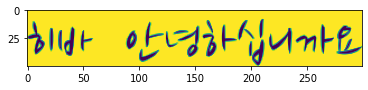

(299, 50)
torch.Size([1, 1, 32, 100])


In [3]:
# read and visualize an image
img = Image.open("./1. 데이터 관련 test/1.png").convert('L')
plt.imshow(img)
plt.show()
print(img.size)

# define the transforms
transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.ToTensor(),
])


img = transform(img)
img = img.to(device)

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Attention(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(Attention, self).__init__()
        self.attention_cell = AttentionCell(input_size, hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.generator = nn.Linear(hidden_size, num_classes)

    def _char_to_onehot(self, input_char, onehot_dim=38):
        input_char = input_char.unsqueeze(1)
        batch_size = input_char.size(0)
        one_hot = torch.FloatTensor(batch_size, onehot_dim).zero_().to(device)
        one_hot = one_hot.scatter_(1, input_char, 1)
        return one_hot

    def forward(self, batch_H, text, is_train=True, batch_max_length=25):
        """
        input:
            batch_H : contextual_feature H = hidden state of encoder. [batch_size x num_steps x contextual_feature_channels]
            text : the text-index of each image. [batch_size x (max_length+1)]. +1 for [GO] token. text[:, 0] = [GO].
        output: probability distribution at each step [batch_size x num_steps x num_classes]
        """
        batch_size = batch_H.size(0)
        num_steps = batch_max_length + 1  # +1 for [s] at end of sentence.

        output_hiddens = torch.FloatTensor(batch_size, num_steps, self.hidden_size).fill_(0).to(device)
        hidden = (torch.FloatTensor(batch_size, self.hidden_size).fill_(0).to(device),
                  torch.FloatTensor(batch_size, self.hidden_size).fill_(0).to(device))

        if is_train:
            for i in range(num_steps):
                # one-hot vectors for a i-th char. in a batch
                char_onehots = self._char_to_onehot(text[:, i], onehot_dim=self.num_classes)
                # hidden : decoder's hidden s_{t-1}, batch_H : encoder's hidden H, char_onehots : one-hot(y_{t-1})
                hidden, alpha = self.attention_cell(hidden, batch_H, char_onehots)
                output_hiddens[:, i, :] = hidden[0]  # LSTM hidden index (0: hidden, 1: Cell)
            probs = self.generator(output_hiddens)

        else:
            targets = torch.LongTensor(batch_size).fill_(0).to(device)  # [GO] token
            probs = torch.FloatTensor(batch_size, num_steps, self.num_classes).fill_(0).to(device)

            for i in range(num_steps):
                char_onehots = self._char_to_onehot(targets, onehot_dim=self.num_classes)
                hidden, alpha = self.attention_cell(hidden, batch_H, char_onehots)
                probs_step = self.generator(hidden[0])
                probs[:, i, :] = probs_step
                _, next_input = probs_step.max(1)
                targets = next_input

        return probs  # batch_size x num_steps x num_classes


class AttentionCell(nn.Module):

    def __init__(self, input_size, hidden_size, num_embeddings):
        super(AttentionCell, self).__init__()
        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)  # either i2i or h2h should have bias
        self.score = nn.Linear(hidden_size, 1, bias=False)
        self.rnn = nn.LSTMCell(input_size + num_embeddings, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, prev_hidden, batch_H, char_onehots):
        # [batch_size x num_encoder_step x num_channel] -> [batch_size x num_encoder_step x hidden_size]
        batch_H_proj = self.i2h(batch_H)
        prev_hidden_proj = self.h2h(prev_hidden[0]).unsqueeze(1)
        e = self.score(torch.tanh(batch_H_proj + prev_hidden_proj))  # batch_size x num_encoder_step * 1

        alpha = F.softmax(e, dim=1)
        context = torch.bmm(alpha.permute(0, 2, 1), batch_H).squeeze(1)  # batch_size x num_channel
        concat_context = torch.cat([context, char_onehots], 1)  # batch_size x (num_channel + num_embedding)
        cur_hidden = self.rnn(concat_context, prev_hidden)
        return cur_hidden, alpha

# input_tensor = torch.arange(0, 0.6656, 0.0001)
# input_tensor = input_tensor.view(26, -1)
# input_tensor = input_tensor.cuda()
# print(input_tensor.shape)

# Attention(input_tensor.unsqueeze(dim=0),)

In [ ]:

# print(type(text),text.shape) <class 'torch.Tensor'>  torch.Size([1024, 26])
# print(type(is_train),is_train) <class 'bool'> True

In [ ]:
# text, length = converter.encode(labels, batch_max_length=opt.batch_max_length)
# converter = AttnLabelConverter(opt.character)

In [9]:


temp_str = ["히바 안녕하십니까요"]
## 리스트+str로 컨버팅
text, length = converter.encode(temp_str, batch_max_length=25)
print(text, length,"\n\n")
print(text.shape,length.shape)
## 결과는 원핫인코딩의 결과값
## 모델에서 선언한 최대길이만큼 인코딩값을 넘김






tensor([[  0, 410, 165,   4, 328, 612, 182, 320,   5, 113, 111,   1,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
       device='cuda:0') tensor([11], device='cuda:0', dtype=torch.int32) 


torch.Size([1, 27]) torch.Size([1])


In [11]:
target = text[:, 1:]

preds = model(img, text[:, :-1]) 
print(preds.shape,preds)

torch.Size([1, 26, 3008]) tensor([[[-2.2058,  1.7116,  4.1822,  ..., -3.5102, -1.1886, -1.0446],
         [-1.4583,  1.1059,  3.4244,  ..., -2.6756, -0.9503, -2.0090],
         [-2.7208,  7.8150,  0.6539,  ..., -2.2769, -3.1042, -1.2225],
         ...,
         [-1.4385, 21.6422,  0.2105,  ..., -0.5547, -2.7575, -2.4282],
         [-1.4362, 21.6382,  0.2167,  ..., -0.5546, -2.7556, -2.4268],
         [-1.4340, 21.6344,  0.2221,  ..., -0.5543, -2.7538, -2.4257]]],
       device='cuda:0', grad_fn=<AddBackward0>)


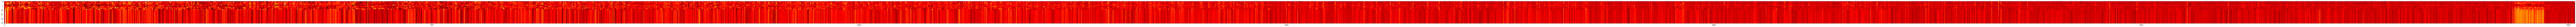

In [25]:
## 결과값 어텐션스코어맵
viz=preds.data
viz = viz[0,:,:]
plt.figure(figsize=(300, 50))
plt.imshow(viz.to("cpu"), cmap='hot')
plt.axis("off")
plt.savefig(f"attention_map.png")